# iCAT Overlay
---
#### Overview
This notebook walks through the procedure for overlaying the fluorescence stacks onto the low magnification EM stacks. Nothing in here is computationally intensive as the registration procedure relies only on the registration metadata created at the time of acquisition. Stacks are specified as `over` (fluorescence channels) or `undr` (low magnification EM)

#### Packages

In [1]:
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

#### Settings

In [2]:
# pandas display settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 15)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

## Set up `render-ws` environment
---

In [3]:
import renderapi
from icatapi.render_pandas import create_stacks_DataFrame

In [7]:
# `render` project parameters
# ---------------------------
owner = 'rlane'
project = 'pancreas'
stacks_2_overlay = {
    'over': ['Hoechst', 'AF594'],
    'undr': 'EM_lomag',
}

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'sonic.tnw.tudelft.nl',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://sonic.tnw.tudelft.nl',
 'port': 8080,
 'owner': 'rlane',
 'project': 'pancreas',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

In [8]:
# Infer stack and section info
# ----------------------------
stacks = renderapi.render.get_stacks_by_owner_project(render=render)

# Output
# ------
out = f"""\
all stacks.......... {stacks}
stacks to overlay... {stacks_2_overlay}
...
"""
print(out)

# Create stacks DataFrame
# ------------------------
df_project = create_stacks_DataFrame(stacks=stacks_2_overlay['over'] +\
                                           [stacks_2_overlay['undr']],
                                     render=render)
df_project.groupby('stack')\
          .apply(lambda x: x.sample(3))

all stacks.......... ['EM_himag_stitched', 'EM_himag_montaged', 'Hoechst', 'EM_lomag', 'EM_himag', 'AF594']
stacks to overlay... {'over': ['Hoechst', 'AF594'], 'undr': 'EM_lomag'}
...



tileId    z   width  height   minint   maxint  \
stack                                                                
AF594    6   aaa_insulin...  6.0  2048.0  2048.0    445.0    890.0   
         5   aaa_insulin...  5.0  2048.0  2048.0    439.0    878.0   
         7   aaa_insulin...  7.0  2048.0  2048.0    439.0    878.0   
EM_lomag 8   aaa_big_EM-...  4.0  4096.0  4096.0  31678.0  34295.0   
         9   aaa_big_EM-...  5.0  4096.0  4096.0  31586.0  34319.0   
         10  aaa_big_EM-...  6.0  4096.0  4096.0  31639.0  34260.0   
Hoechst  1   aaa_hoechst...  5.0  2048.0  2048.0    870.0   1740.0   
         3   aaa_hoechst...  7.0  2048.0  2048.0    864.0   1728.0   
         2   aaa_hoechst...  6.0  2048.0  2048.0    884.0   1768.0   

                   imageUrl          tforms     stack sectionId  imageRow  \
stack                                                                       
AF594    6   https://son...  [M=[[1.0000...     AF594      S006         1   
         5   https://son...  [M=[[1.0000...     AF594      S005         1   
         7   https://son...  [M=[[1.0000...     AF594      S007         1   
EM_lomag 8   https://son...  [M=[[1.0000...  EM_lomag      S004         1   
         9   https://son...  [M=[[1.0000...  EM_lomag      S005         1   
         10  https://son...  [M=[[1.0000...  EM_lomag      S006         1   
Hoechst  1   https://son...  [M=[[1.0000...   Hoechst      S005         1   
         3   https://son...  [M=[[1.0000...   Hoechst      S007         1   
         2   https://son...  [M=[[1.0000...   Hoechst      S006         1   

             imageCol       stageX       stageY  
stack                                            
AF594    6          1  2227.808609  6381.567861  
         5          1  1622.072408  6381.077600  
         7          1  2832.009499  6381.316683  
EM_lomag 8          1  1021.110000  6371.003000  
         9          1  1621.125000  6381.079000  
         10         1  2226.245000  6381.133000  
Hoechst  1          1  1622.072408  6381.077600  
         3          1  2832.009499  6381.316683  
         2          1  2227.808609  6381.567861

## Compute overlay transforms
---

### Sample overlay transform

In [9]:
from icatapi.overlay import get_transform_metadata

In [13]:
# Choose random FM image tile filepath
fp = Path(df_project.loc[df_project['stack'].isin(stacks_2_overlay['over'] +\
                                                 [stacks_2_overlay['undr']])]\
                    .sample(1)['imageUrl']\
                    .str.split('.nl')\
                    .iloc[0][1])

# Test parser
tform_md = get_transform_metadata(fp)
(psx, psy), ro, sh, (trx, try_) = list(tform_md.values())[0]

# Output
out = f"""\
File.......... {fp.parent.name}/{fp.name}
Pixel size.... ({1e9*psx:.1f}nm, {1e9*psy:.1f}nm)
Rotation...... {np.rad2deg(ro):.1f}°
Shear......... {sh:.2e}
Translation... ({1e6*trx:.1f}um, {1e6*try_:.1f}um)
"""
print(out)

File.......... S005/big_EM-00001x00001.tif
Pixel size.... (33.9nm, 33.2nm)
Rotation...... 0.0°
Shear......... 6.64e-03
Translation... (1621.1um, 6381.1um)



### Compile transform data

In [14]:
from itertools import product

In [17]:
# Create multiindex
overlay_cols = ['stack', 'z', 'sectionId',
                'tileId', 'imageRow', 'imageCol',
                'width', 'height',
                'imageUrl', 'tforms',
                'overlay_transforms']
multiindex = np.array(list(product(overlay_cols,
                                   ['EM', 'FM']))).T.tolist()
# Initialize overlay DataFrame
df_overlay = pd.DataFrame(columns=multiindex)

# Loop through overlay stacks
for stack in stacks_2_overlay['over']:
    # Filter to stack DataFrame
    df_stack = df_project.loc[(df_project['stack'] == stack)].copy()

    # Loop through FM tiles
    for i, FM_tile in df_stack.iterrows():

        # Find correlative EM tile
        EM_tile = df_project.loc[(df_project['stack'] == stacks_2_overlay['undr']) &\
                                 (df_project['z'] == FM_tile['z']) &\
                                 (df_project['imageRow'] == FM_tile['imageRow']) &\
                                 (df_project['imageCol'] == FM_tile['imageCol'])].iloc[0]

        # Build up overlay DataFrame one FM tile at a time
        df_overlay.loc[i, 'stack'] = EM_tile['stack'], FM_tile['stack']
        df_overlay.loc[i, 'z'] = EM_tile['z'], FM_tile['z']
        df_overlay.loc[i, 'sectionId'] = EM_tile['sectionId'], FM_tile['sectionId']
        df_overlay.loc[i, 'tileId'] = EM_tile['tileId'], FM_tile['tileId']
        df_overlay.loc[i, 'imageRow'] = EM_tile['imageRow'], FM_tile['imageRow']
        df_overlay.loc[i, 'imageCol'] = EM_tile['imageCol'], FM_tile['imageCol']
        df_overlay.loc[i, 'width'] = EM_tile['width'], FM_tile['width']
        df_overlay.loc[i, 'height'] = EM_tile['height'], FM_tile['height']
        df_overlay.loc[i, 'imageUrl'] = EM_tile['imageUrl'], FM_tile['imageUrl']
        df_overlay.at[i, ('tforms', 'EM')] = EM_tile['tforms']
        df_overlay.at[i, ('tforms', 'FM')] = FM_tile['tforms']

# Preview
df_overlay.groupby(('stack', 'FM'))\
          .apply(lambda x: x.head(5))

stack             z      sectionId                tileId  \
                     EM       FM   EM   FM        EM    FM              EM   
(stack, FM)                                                                  
AF594       4  EM_lomag    AF594  4.0  4.0      S004  S004  aaa_big_EM-...   
            5  EM_lomag    AF594  5.0  5.0      S005  S005  aaa_big_EM-...   
            6  EM_lomag    AF594  6.0  6.0      S006  S006  aaa_big_EM-...   
            7  EM_lomag    AF594  7.0  7.0      S007  S007  aaa_big_EM-...   
Hoechst     0  EM_lomag  Hoechst  4.0  4.0      S004  S004  aaa_big_EM-...   
            1  EM_lomag  Hoechst  5.0  5.0      S005  S005  aaa_big_EM-...   
            2  EM_lomag  Hoechst  6.0  6.0      S006  S006  aaa_big_EM-...   
            3  EM_lomag  Hoechst  7.0  7.0      S007  S007  aaa_big_EM-...   

                              imageRow     ...   width          height  \
                           FM       EM FM  ...      EM      FM      EM   
(stack, FM)                                ...                           
AF594       4  aaa_insulin...        1  1  ...  4096.0  2048.0  4096.0   
            5  aaa_insulin...        1  1  ...  4096.0  2048.0  4096.0   
            6  aaa_insulin...        1  1  ...  4096.0  2048.0  4096.0   
            7  aaa_insulin...        1  1  ...  4096.0  2048.0  4096.0   
Hoechst     0  aaa_hoechst...        1  1  ...  4096.0  2048.0  4096.0   
            1  aaa_hoechst...        1  1  ...  4096.0  2048.0  4096.0   
            2  aaa_hoechst...        1  1  ...  4096.0  2048.0  4096.0   
            3  aaa_hoechst...        1  1  ...  4096.0  2048.0  4096.0   

                             imageUrl                          tforms  \
                   FM              EM              FM              EM   
(stack, FM)                                                             
AF594       4  2048.0  https://son...  https://son...  [M=[[1.0000...   
            5  2048.0  https://son...  https://son...  [M=[[1.0000...   
            6  2048.0  https://son...  https://son...  [M=[[1.0000...   
            7  2048.0  https://son...  https://son...  [M=[[1.0000...   
Hoechst     0  2048.0  https://son...  https://son...  [M=[[1.0000...   
            1  2048.0  https://son...  https://son...  [M=[[1.0000...   
            2  2048.0  https://son...  https://son...  [M=[[1.0000...   
            3  2048.0  https://son...  https://son...  [M=[[1.0000...   

                              overlay_transforms       
                           FM                 EM   FM  
(stack, FM)                                            
AF594       4  [M=[[1.0000...             NaN     NaN  
            5  [M=[[1.0000...             NaN     NaN  
            6  [M=[[1.0000...             NaN     NaN  
            7  [M=[[1.0000...             NaN     NaN  
Hoechst     0  [M=[[1.0000...             NaN     NaN  
            1  [M=[[1.0000...             NaN     NaN  
            2  [M=[[1.0000...             NaN     NaN  
            3  [M=[[1.0000...             NaN     NaN  

[8 rows x 22 columns]

### Compute overlay transforms

In [18]:
from renderapi.transform import AffineModel
from icatapi.overlay import compute_relative_transform_from_filepaths

In [24]:
# Iterate through CLEM tiles
for i, tile in tqdm(df_overlay.iterrows(), total=len(df_overlay)):

    # Initial translation derived from stage position
    T0_EM = tile[('tforms', 'EM')][-1]
    T0_FM = tile[('tforms', 'FM')][-1]

    # Overlay translation to center tiles
    C0_EM = AffineModel(B0=-tile[('width', 'EM')]/2,
                        B1=-tile[('height', 'EM')]/2)
    C0_FM = AffineModel(B0=-tile[('width', 'FM')]/2,
                        B1=-tile[('height', 'FM')]/2)

    # Compute relative transform
    fp_EM = Path(tile[('imageUrl', 'EM')].split('.nl')[1])
    fp_FM = Path(tile[('imageUrl', 'FM')].split('.nl')[1])
    A = AffineModel()
    A.M = compute_relative_transform_from_filepaths(fp_EM, fp_FM)

    # Set overlay transforms
    df_overlay.at[i, ('overlay_transforms', 'EM')] = [C0_EM, T0_EM]
    df_overlay.at[i, ('overlay_transforms', 'FM')] = [C0_FM, A, T0_EM]

# Preview sample overlay transform
sample = df_overlay.sample(1)
out = f"""\
{sample[('tileId', 'EM')].iloc[0]} | \
{sample[('tileId', 'FM')].iloc[0]}
"""
print(out)
sample['overlay_transforms'].values.tolist()

  0%|          | 0/8 [00:00<?, ?it/s]

aaa_big_EM-S005-00001x00001 | aaa_insulin-S005-00001x00001



[[[M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-2048.000000,-2048.000000],
   M=[[1.000000,0.000000],[0.000000,1.000000]] B=[0.000000,0.000000]],
  [M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-1024.000000,-1024.000000],
   M=[[3.115204,-0.373079],[0.359951,3.184614]] B=[27.928347,0.042149],
   M=[[1.000000,0.000000],[0.000000,1.000000]] B=[0.000000,0.000000]]]]

## Upload overlaid stacks to `render-ws`
---

### Create overlaid stacks

In [25]:
from renderapi.tilespec import TileSpec

In [26]:
# Collect overlay stacks
stacks_overlaid = []

# Iterate through stacks
for stack in tqdm(stacks_2_overlay['over'] +\
                 [stacks_2_overlay['undr']]):

    # Set overlay stack name
    stack_overlaid = f"{stack}_overlaid"
    stacks_overlaid.append(stack_overlaid)

    # Get stack DataFrame
    df_stack = df_project.loc[(df_project['stack'] == stack)].copy()

    # Create `TileSpec`s
    tile_specs = []
    for i, tile in df_stack.iterrows():

        # Get overlay transforms for each tile from overlay DataFrame
        k = 'FM' if stack in stacks_2_overlay['over'] else 'EM' 
        tile['tforms'] = df_overlay.loc[(df_overlay[('stack', k)] == tile['stack']) &\
                                        (df_overlay[('z', k)] == tile['z']) &\
                                        (df_overlay[('imageRow', k)] == tile['imageRow']) &\
                                        (df_overlay[('imageCol', k)] == tile['imageCol']),
                                        ('overlay_transforms', k)].iloc[0]

        # Create `TileSpec
        ts = TileSpec(**tile.to_dict())
        tile_specs.append(ts)

    # Create stack
    renderapi.stack.create_stack(stack_overlaid,
                                 render=render)
    # Import TileSpecs to render
    renderapi.client.import_tilespecs(stack_overlaid,
                                      tile_specs,
                                      render=render)
    # Set stack state to complete
    renderapi.stack.set_stack_state(stack_overlaid,
                                    'COMPLETE',
                                    render=render)

  0%|          | 0/3 [00:00<?, ?it/s]

## Inspect overlaid stacks
---

### Tile map

In [27]:
from icatapi.plotting import plot_tile_map, plot_stacks

  0%|          | 0/4 [00:00<?, ?it/s]

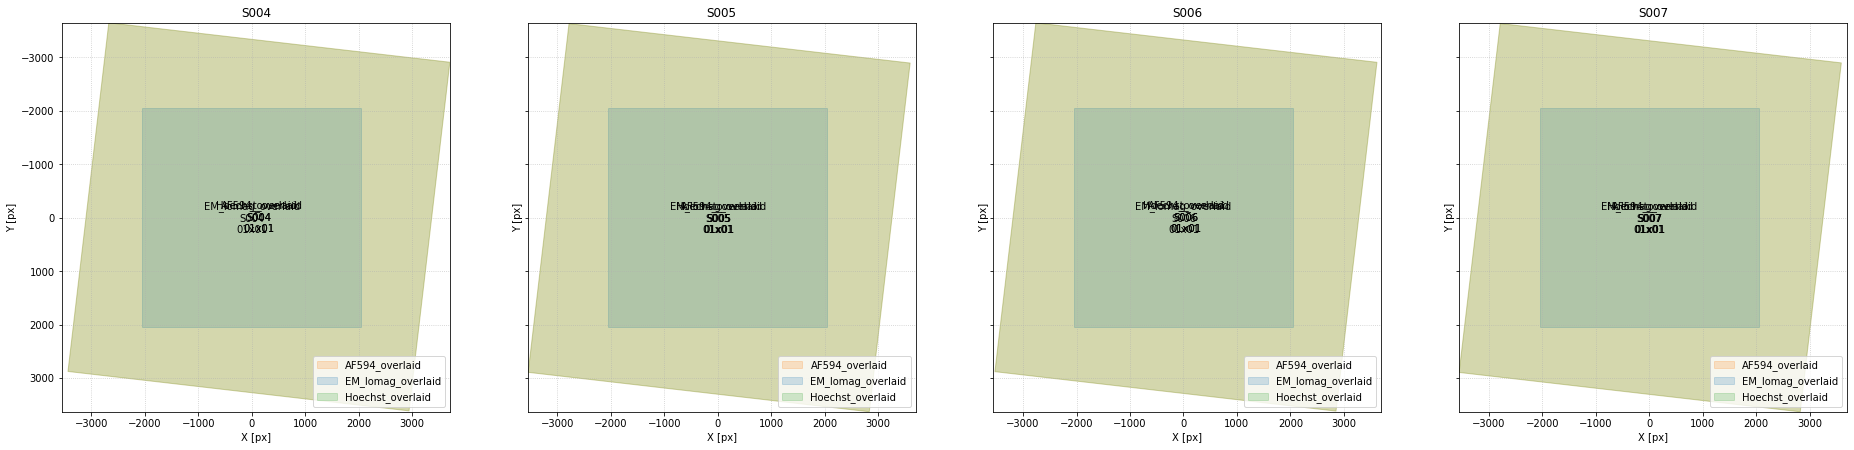

In [28]:
# Choose stacks to plot
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
stacks_2_plot = [stack for stack in stacks if 'overlaid' in stack]

# Plot tile maps
plot_tile_map(stacks=stacks_2_plot,
              render=render)

### Render images

  0%|          | 0/12 [00:00<?, ?it/s]

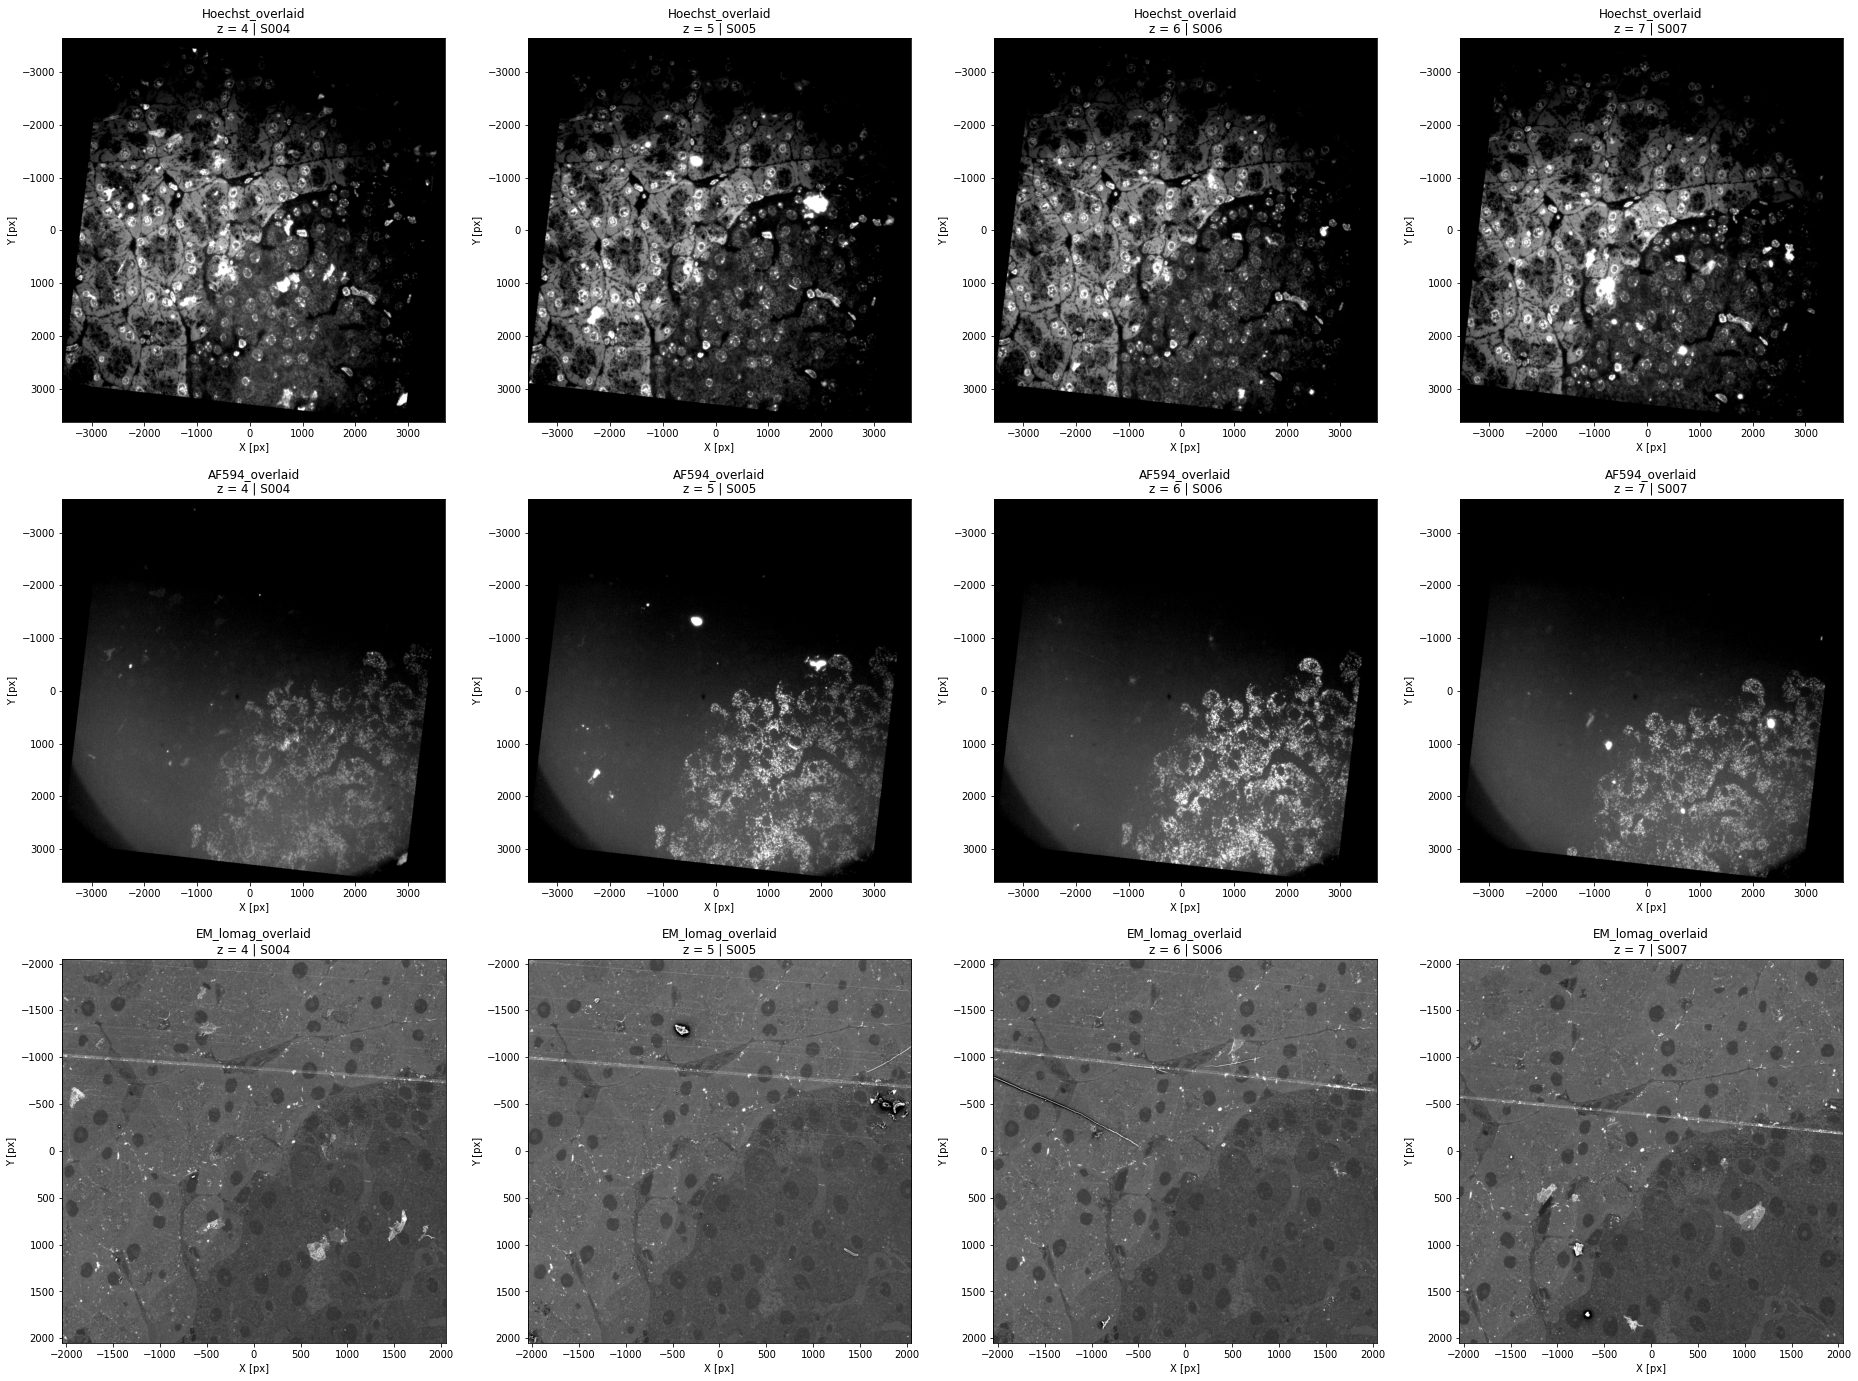

In [29]:
# Specify stacks and sections
stacks_2_plot = stacks_overlaid

# Plot stacks
plot_stacks(stacks=stacks_overlaid,
            render=render)